In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


In [2]:
count = 0 
dirs = os.listdir('./Dataset')  # Change dataset path here
for dir in dirs:
    path = os.path.join('./Dataset', dir)
    if os.path.isdir(path):  # Ensure it's a directory, not a file (like k.ipynb)
        files = list(os.listdir(path))  # List files inside each category folder
        print(dir + ' Folder has ' + str(len(files)) + ' Images')  
        count += len(files)

print('Images Folder has ' + str(count) + ' Images')  


Bus Folder has 100 Images
Car Folder has 100 Images
motorcycle Folder has 100 Images
Truck Folder has 100 Images
Images Folder has 400 Images


In [3]:
base_dir = './Dataset'  # Main dataset folder containing Bus, Car, Motorcycle, and Truck
val_dir = './Validation/'  # Adjusted validation dataset folder if you have one
# img_size = 180  # Resize images to 180x180 pixels
img_size = 128
# batch = 32  # Set batch size for training
batch = 16

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

# Check the number of classes detected
print("Classes:", train_ds.class_names) 

Found 400 files belonging to 4 classes.
Using 320 files for training.
Found 400 files belonging to 4 classes.
Using 80 files for validation.
Classes: ['Bus', 'Car', 'Truck', 'motorcycle']


In [5]:
vehicle_names = train_ds.class_names  # Get the list of class names
print(vehicle_names)  # Print the class names

['Bus', 'Car', 'Truck', 'motorcycle']


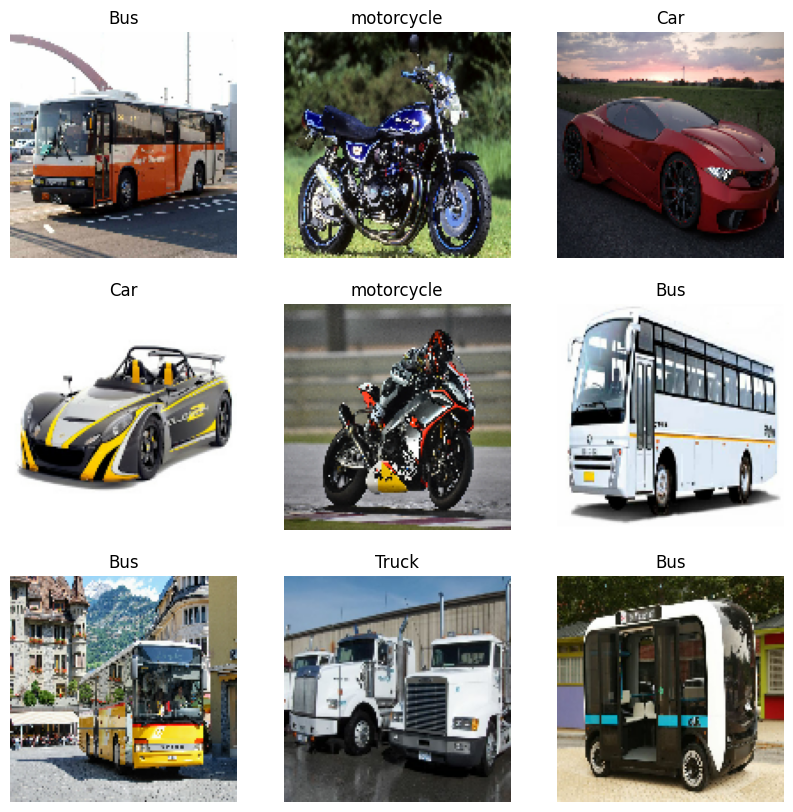

In [10]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(vehicle_names[labels[i].numpy()])  
        plt.axis('off')

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [13]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

c:\Users\AARAV\OneDrive\Desktop\python\virtual\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


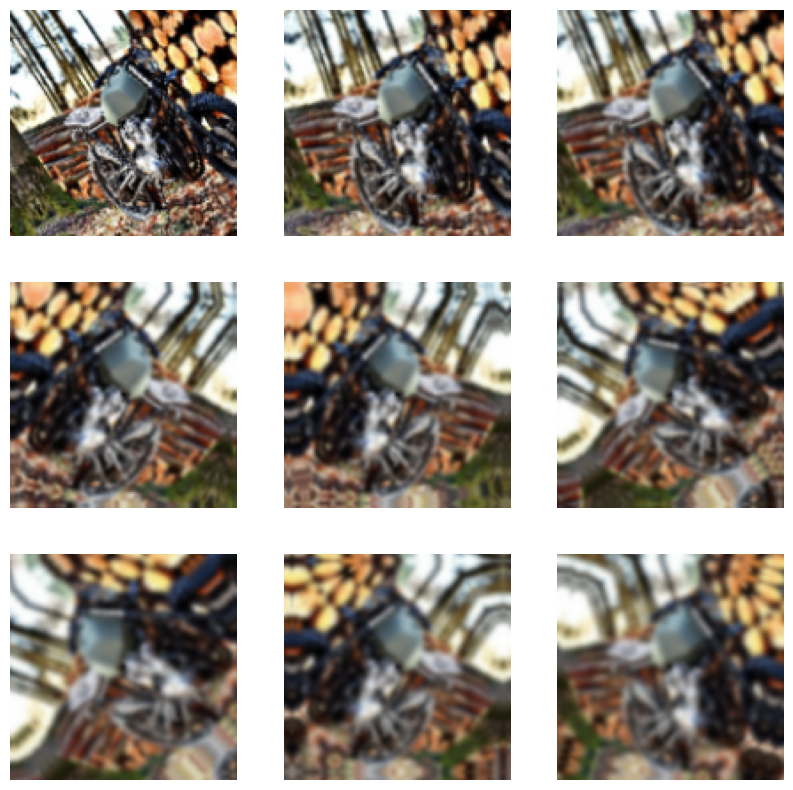

In [19]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [20]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,509 (8.09 MB)

 Trainable params: 2,121,509 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.2702 - loss: 1.5471 - val_accuracy: 0.4000 - val_loss: 1.3329
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2938 - loss: 1.3766 - val_accuracy: 0.4500 - val_loss: 1.2413
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5382 - loss: 1.1243 - val_accuracy: 0.5375 - val_loss: 1.1417
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6111 - loss: 0.9335 - val_accuracy: 0.5375 - val_loss: 1.0936
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5775 - loss: 1.0360 - val_accuracy: 0.6250 - val_loss: 0.9981
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.6820 - loss: 0.8361 - val_accuracy: 0.6000 - val_loss: 1.2626
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.6863 - loss: 0.8134 - val_accuracy: 0.5125 - val_loss: 1.0797
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.6594 - loss: 0.8386 - val_accuracy: 0.6250 - val

In [24]:
model.save('vehicle_classification.keras')


Text(0.5, 1.0, 'Training & Validation Accuracy')

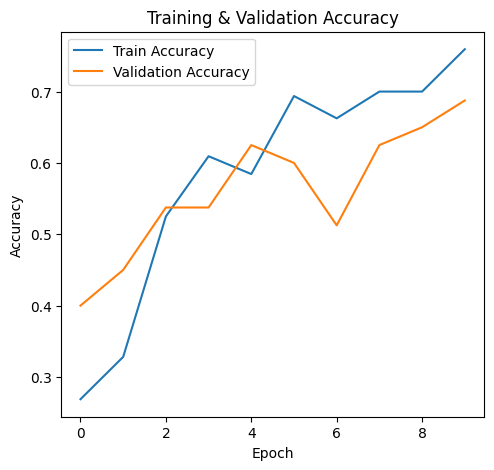

In [25]:
#  graph and confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot Training Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

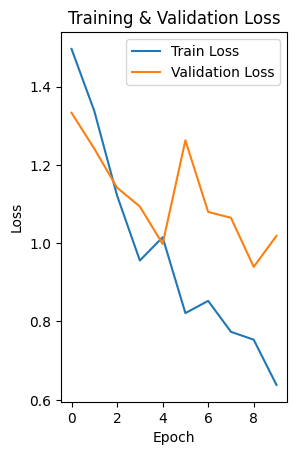

In [26]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')



In [27]:
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


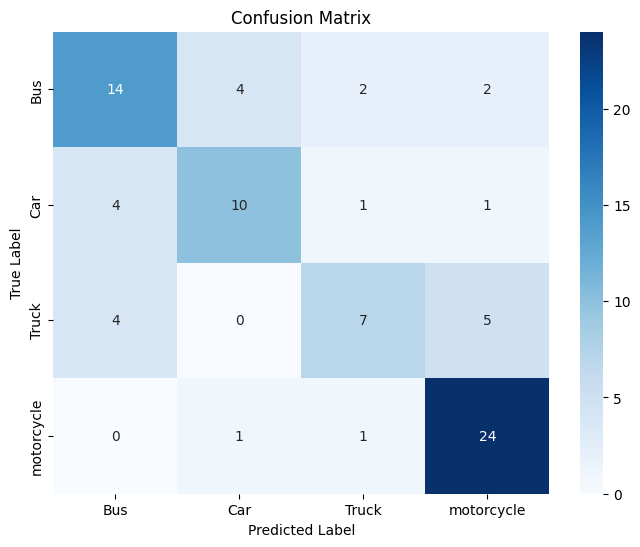

Classification Report:
               precision    recall  f1-score   support

         Bus       0.64      0.64      0.64        22
         Car       0.67      0.62      0.65        16
       Truck       0.64      0.44      0.52        16
  motorcycle       0.75      0.92      0.83        26

    accuracy                           0.69        80
   macro avg       0.67      0.66      0.66        80
weighted avg       0.68      0.69      0.68        80



In [28]:
# Confusion Matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=vehicle_names, yticklabels=vehicle_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=vehicle_names))
# ya samma

In [29]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(128,128))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + vehicle_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

tf.keras.models.load_model('vehicle_classification.keras')

<Sequential name=sequential_1, built=True>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(-0.5, 473.5, 265.5, -0.5)

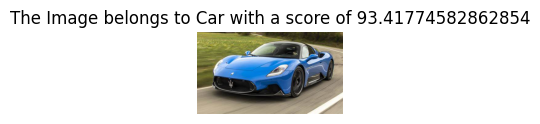

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgPath = 'test.jpg'
prediction = classify_images(imgPath)
plt.subplot(3,3,3)
plt.imshow(mpimg.imread(imgPath))
plt.title(prediction)
plt.axis('off')

In [ ]:
# .py file ma matra chalxa.
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load trained model
model = tf.keras.models.load_model('vehicle_classification.keras')

# Class names
vehicle_names = ['Bus', 'Car', 'Motorcycle', 'Truck']

# Function to classify image
def classify_images(image):
    input_image = image.resize((128, 128))
    input_image_array = np.array(input_image) / 255.0  # Normalize
    input_image_exp_dim = np.expand_dims(input_image_array, axis=0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    
    outcome = f"The image belongs to **{vehicle_names[np.argmax(result)]}** with a confidence score of **{np.max(result) * 100:.2f}%**"
    return outcome

# Streamlit UI
st.title("🚗 Vehicle Classification")
st.write("Upload an image to classify whether it's a Bus, Car, Motorcycle, or Truck.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)
    
    st.write("Classifying...")
    prediction = classify_images(image)
    st.success(prediction)


In [45]:
import tkinter as tk
from tkinter import filedialog, Label, Button, Frame
import tensorflow as tf
import numpy as np
from PIL import Image, ImageTk

# Load trained model
model = tf.keras.models.load_model('vehicle_classification.keras')

# Class names with emojis
vehicle_names = ['🚌 Bus', '🚗 Car', '🏍️ Motorcycle', '🚛 Truck']

# Function to classify an image
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(128, 128))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    
    outcome = f"🎯 This image is a {vehicle_names[np.argmax(result)]} with {np.max(result) * 100:.2f}% accuracy!" 
    return outcome

# Function to open file dialog and classify selected image
def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    
    if file_path:
        # Display image
        img = Image.open(file_path)
        img = img.resize((250, 250))  # Resize for display
        img = ImageTk.PhotoImage(img)

        image_label.config(image=img)
        image_label.image = img

        # Classify image
        prediction = classify_images(file_path)
        result_label.config(text=prediction, fg="#FFD700")  # Golden text

# Create Tkinter window
root = tk.Tk()
root.title("🚀 Vehicle Classifier 🏎️")
root.geometry("600x700")
root.configure(bg="#1E3A8A")  # Deep blue background

# Frame for styling
frame = Frame(root, bg="#FFFFFF", bd=5, relief="ridge", highlightbackground="#FFD700", highlightthickness=3)
frame.pack(pady=30, padx=30, fill="both", expand=True)

# Title label
title_label = Label(frame, text="🏎️ Vehicle Classifier 🏁", font=("Arial", 20, "bold"), fg="#1E3A8A", bg="#FFFFFF")
title_label.pack(pady=15)

# Upload button
upload_button = Button(frame, text="📸 Select an Image", command=upload_image, font=("Arial", 14, "bold"), 
                       bg="#FFD700", fg="#1E3A8A", padx=12, pady=8, relief="raised", cursor="hand2")
upload_button.pack(pady=20)

# Image display label
image_label = Label(frame, bg="#FFFFFF", bd=2, relief="ridge")
image_label.pack(pady=15)

# Result label
result_label = Label(frame, text="", font=("Arial", 14, "bold"), fg="#E74C3C", bg="#FFFFFF", wraplength=450, justify="center")
result_label.pack(pady=25)

# Run the GUI
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
